# Классификация текстовой информации

##Подход на основе bag of words

In [118]:
# Импорт набора данных из sklearn.datasets

from sklearn.datasets import fetch_20newsgroups # Набор данных - посты-обсуждения новостей определенных категорий
cat = ['talk.religion.misc','soc.religion.christian'] # Выбираем две категории для классификации
# Данные для обучения
twenty_train = fetch_20newsgroups(subset='train', categories = cat, shuffle=True, random_state=1
                                  ,remove=('headers', 'footers', 'quotes'))
# Данне для проверки
twenty_test = fetch_20newsgroups(subset='test', categories = cat, shuffle=True, random_state=1
                                  ,remove=('headers', 'footers', 'quotes'))

In [119]:
# Кусочек данных

print 'Text: \n' + str(twenty_train.data[0]) + '\n\nClass: \n' + str(twenty_train.target[0])

Text: 


While I agree with most of Jon says (I deleted those parts, of course), I 
have serious reservations about this advice.  Maintaining a `just 
friends' level of relationship is much easier said than done.  People 
usually end up getting hurt.  This is especially likely to happen when 
they start off with feelings of attraction.  

When people feel attracted those feelings can cloud their judgement.  
I've had the experience of going quickly from believing that I shouldn't 
date non-Christians to believing that dating this man would be okay to 
believing that premarital sex is fine when people really love each 
other.  When the relationship ended my beliefs immediately returned to 
their original state.  

This is an especially extreme case because I was young and away from home 
and fellowship.  I don't think it would work exactly this way for most 
people.  However, it's important not to underestimate the power of 
feelings of attraction.  

Class: 
0


In [120]:
# Размер обучающей и тестовой выборок
print 'Train sample size: ' + str(len(twenty_train.data))
print 'Test sample size: ' + str(len(twenty_test.data))
# Соотношение классов
print 'Test class 1 share: ' + str(sum(twenty_train.target)/float(len(twenty_train.target)))
print 'Test class 1 share: ' + str(sum(twenty_test.target)/float(len(twenty_test.target)))

Train sample size: 976
Test sample size: 649
Test class 1 share: 0.386270491803
Test class 1 share: 0.386748844376


In [121]:
# Импорт необходимых пакетов
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold
from sklearn.metrics import roc_curve, auc, precision_recall_curve, roc_auc_score

In [122]:
# Импорт и создание векторайзеров
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizers = {'CountVect': CountVectorizer(binary = False), 'CountVectBin': CountVectorizer(binary = True), 'TFIDFVect': TfidfVectorizer()}

In [123]:
for i in vectorizers:
    print vectorizers[i]

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)
CountVectorizer(analyzer=u'word', binary=True, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max

In [124]:
vectorized_text = {}
for i in vectorizers:
    vectorized_text[i] = vectorizers[i].fit_transform(twenty_train.data)

In [125]:
vectorized_text

{'CountVect': <976x15748 sparse matrix of type '<type 'numpy.int64'>'
 	with 118763 stored elements in Compressed Sparse Row format>,
 'CountVectBin': <976x15748 sparse matrix of type '<type 'numpy.int64'>'
 	with 118763 stored elements in Compressed Sparse Row format>,
 'TFIDFVect': <976x15748 sparse matrix of type '<type 'numpy.float64'>'
 	with 118763 stored elements in Compressed Sparse Row format>}

In [126]:
# csr_matrix - часто используемый эффективный объект для хранения разреженных матриц
# indices  - массив индексов столбцов
# data - массив ненулевых элементов матрицы
# indptr  - массив указателей на начала новых строк в индексах и данных
import scipy.sparse as sps
csr_matrix_example = sps.csr_matrix([[1, 0, 0], [0, 5, 0], [0, 2, 3], [7, 0, 10]])
print csr_matrix_example.toarray()
print 'indices = ' + str(csr_matrix_example.indices)
print 'data = ' + str(csr_matrix_example.data)
print 'indptr = ' + str(csr_matrix_example.indptr)

[[ 1  0  0]
 [ 0  5  0]
 [ 0  2  3]
 [ 7  0 10]]
indices = [0 1 1 2 0 2]
data = [ 1  5  2  3  7 10]
indptr = [0 1 2 4 6]


In [127]:
# Переменные с метками классов
train_labels = twenty_train.target
test_labels = twenty_test.target

In [128]:
# Функция пересоздания pandas dataframe с результатами кросс-валидации
def df_auc_rebuild():
    global df_line, df_metrics, df_auc
    df_auc = None
    df_line = 0
    columns = ['C', 'AUC train', 'AUC test']
    df_auc = pd.DataFrame(columns=columns)

In [129]:
# Список значений параметра регуляризации для кросс-валидации
C_values = [0.01, 0.05, 0.1, 0.3, 0.5, 1.0, 2.0, 4.0, 6.0, 10.0, 15.0, 20.0, 25.0, 30.0]

In [130]:
# Pandas dataframe для агрегации AUC различных подходов
columns = ['Vectorizer', 'Stemming',  'C', 'CV AUC']
df_auc_agg = pd.DataFrame(columns=columns)

In [131]:
# Функция, выполняющая KFold кросс-валидацию и сохраняющая результаты в pandas dataframe
def run_cv(train_data_ind, stemming):
    train_data = vectorized_text[train_data_ind]
    global df_auc_agg
    df_line = 0
    df_auc_rebuild()
    estimators = []
    kf = KFold(n=train_data.shape[0], n_folds=5, shuffle=True, random_state = 1) # Создание индексов для деления данных на 5 частей
    for C in C_values:
        estimators.append(LogisticRegression(class_weight = 'balanced', penalty = 'l1', C = C))
    for train_index, test_index in kf:
        x_train = train_data[train_index]
        x_test = train_data[test_index]
        y_train = [train_labels[x] for x in train_index]
        y_test = [train_labels[x] for x in test_index]
        for estimator in estimators: # расчет для каждого параметра регуляризации
            estimator.fit(x_train, y_train)
            prediction_train = estimator.predict_proba(x_train)[:, 1]
            prediction_test = estimator.predict_proba(x_test)[:, 1]
            auc_train = roc_auc_score(y_train, prediction_train)
            auc_test = roc_auc_score(y_test, prediction_test)
            cv_stage = [estimator.C, auc_train, auc_test]
            df_auc.loc[df_line] = cv_stage
            df_line += 1
    # Агрегация по параметру регуляризации
    tmp_df_agg = df_auc.groupby(['C'], as_index=False).agg({'AUC train': {'mean':'mean','std':'std'}, 'AUC test': {'mean':'mean','std':'std'}})
    tmp_df_agg.columns = ['C', 'AUC test std', 'AUC test mean', 'AUC train std', 'AUC train mean'] # переименование колонок
    print '\n'+ train_data_ind + '\n'
    print tmp_df_agg    

    df_to_append = tmp_df_agg.sort(('AUC test mean'), ascending=False).head(1) # выбор строки с максимальным AUC
    df_to_append = df_to_append[['C', 'AUC test mean']] # выбор только нужных колонок
    df_to_append.columns = ['C', 'CV AUC'] # переименование выбранных колонок
    df_to_append.insert(0, 'Vectorizer', train_data_ind) # добавление колонок
    df_to_append.insert(1, 'Stemming', stemming) # добавление колонок
    df_auc_agg = df_auc_agg.append(df_to_append, ignore_index=True) # добавление строки в dataframe с агрегатами

In [132]:
for x in vectorized_text:
    run_cv(x, stemming = False)


CountVect

        C  AUC test std  AUC test mean  AUC train std  AUC train mean
0    0.01      0.041009       0.608715       0.026182        0.632707
1    0.05      0.045211       0.681067       0.008323        0.776873
2    0.10      0.038808       0.730066       0.007241        0.869345
3    0.30      0.026303       0.783787       0.001862        0.964008
4    0.50      0.025620       0.792602       0.001337        0.986343
5    1.00      0.024440       0.783832       0.000339        0.997488
6    2.00      0.022152       0.777302       0.000068        0.999462
7    4.00      0.022735       0.777287       0.000052        0.999671
8    6.00      0.024718       0.777691       0.000043        0.999681
9   10.00      0.027815       0.776048       0.000043        0.999681
10  15.00      0.029756       0.774123       0.000043        0.999681
11  20.00      0.030960       0.773466       0.000043        0.999681
12  25.00      0.031170       0.773185       0.000043        0.999681
13  30.0

In [133]:
# Стемминг исходного текста
from nltk import PorterStemmer
ps = PorterStemmer()
import re
stemmed_train_text =  [' '.join([ps.stem_word(x) for x in re.findall(r"[\w']+", y)]) for y in twenty_train.data]

In [134]:
# Словарь векторайзеров для текста после стемминга
vectorizers_stem = {'CountVect': CountVectorizer(binary = False), 'CountVectBin': CountVectorizer(binary = True), 'TFIDFVect': TfidfVectorizer()}

In [135]:
# Векторизация текста со стеммингом
vectorized_stemmed_text_train = {}
for i in vectorizers_stem:
    vectorized_stemmed_text_train[i] = vectorizers_stem[i].fit_transform(stemmed_train_text)

In [136]:
vectorized_stemmed_text_train

{'CountVect': <976x11434 sparse matrix of type '<type 'numpy.int64'>'
 	with 113159 stored elements in Compressed Sparse Row format>,
 'CountVectBin': <976x11434 sparse matrix of type '<type 'numpy.int64'>'
 	with 113159 stored elements in Compressed Sparse Row format>,
 'TFIDFVect': <976x11434 sparse matrix of type '<type 'numpy.float64'>'
 	with 113159 stored elements in Compressed Sparse Row format>}

In [137]:
for x in vectorized_stemmed_text_train:
    run_cv(x, stemming = True)


CountVect

        C  AUC test std  AUC test mean  AUC train std  AUC train mean
0    0.01      0.041017       0.608692       0.026181        0.632705
1    0.05      0.045211       0.681067       0.008318        0.776872
2    0.10      0.038787       0.730089       0.007245        0.869345
3    0.30      0.026324       0.783787       0.001857        0.964004
4    0.50      0.025597       0.792602       0.001338        0.986342
5    1.00      0.024440       0.783832       0.000340        0.997489
6    2.00      0.022162       0.777279       0.000068        0.999462
7    4.00      0.022827       0.777353       0.000052        0.999671
8    6.00      0.024645       0.777783       0.000043        0.999681
9   10.00      0.027919       0.775666       0.000043        0.999681
10  15.00      0.029754       0.774016       0.000043        0.999681
11  20.00      0.031442       0.772895       0.000043        0.999681
12  25.00      0.031105       0.773363       0.000043        0.999681
13  30.0

In [138]:
print 'Best models'
df_auc_agg.sort(('CV AUC'), ascending=False)

Best models


,Vectorizer,Stemming,C,CV AUC
5,TFIDFVect,True,6.0,0.819450
2,TFIDFVect,False,6.0,0.819383
0,CountVect,False,0.5,0.792602
3,CountVect,True,0.5,0.792602
4,CountVectBin,True,1.0,0.790720
1,CountVectBin,False,1.0,0.790584


In [140]:
# Обучение лучшей модели на всей обучающей выборке и расчет AUC на обучающей и тестовой выборках
best_model = LogisticRegression(class_weight = 'balanced', penalty = 'l1', C = 6.0).fit(vectorized_stemmed_text_train['TFIDFVect'], train_labels)

In [141]:
train_auc = roc_auc_score(train_labels, best_model.predict_proba(vectorized_stemmed_text_train['TFIDFVect'])[:, 1])
print 'Train AUC = ' + str(train_auc)

Train AUC = 0.997703953982


In [142]:
stemmed_test_text =  [' '.join([ps.stem_word(x) for x in re.findall(r"[\w']+", y)]) for y in twenty_test.data]
vectorized_stemmed_text_test = vectorizers_stem['TFIDFVect'].transform(stemmed_test_text)
test_auc = roc_auc_score(test_labels, best_model.predict_proba(vectorized_stemmed_text_test)[:, 1])
print 'Test AUC = ' + str(test_auc)

Test AUC = 0.774264750045


In [143]:
print 'Число ненулевых коэффициентов в модели: ' + str(sum(best_model.coef_[0] != 0))

Число ненулевых коэффициентов в модели: 347


In [145]:
# Функция для отображения K фич с наибольшими абсолютными значениями коэффициентов
def show_topK(classifier, vectorizer, K):
    feature_names = np.asarray(vectorizer.get_feature_names())
    topK = np.argsort(abs(classifier.coef_[0]))[::-1][:K]
    for i in zip(feature_names[topK],classifier.coef_[0][topK]):
        print i[0] + '\t' + str(i[1])

In [146]:
show_topK(best_model, vectorizers_stem['TFIDFVect'], 20)

brian	17.3031161512
lds	16.6843269812
our	-15.9634754765
alway	-15.410267546
kent	14.1991034991
order	13.1810722083
muhammad	12.683270369
need	-11.7835125353
clh	-9.77742208237
jame	-9.60930714041
josephu	9.3403498103
becaus	-9.28153490072
mr	8.95907272571
marriag	-8.63978375204
in	-8.30210524633
church	-8.24936056067
revel	-8.08241306474
out	8.08196182373
for	-8.05760970818
666	7.97527372139


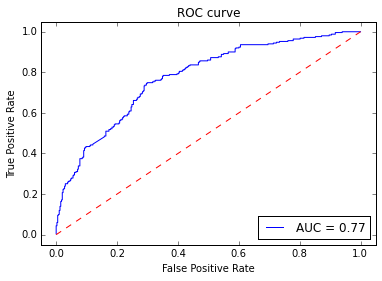

In [148]:
# ROC-кривая на тестовых данных
y_scores = best_model.predict_proba(vectorized_stemmed_text_test)[:, 1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels, y_scores)
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('ROC curve')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% test_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

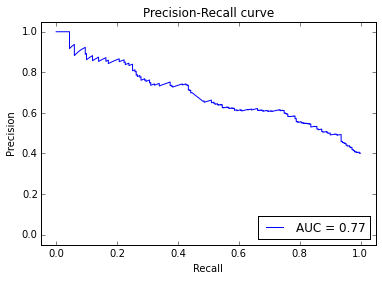

In [149]:
# Precision-Recall кривая на тестовых данных
# precision = tp / (tp + fp), recall = tp / (tp + fn)
precision, recall, thresholds = precision_recall_curve(test_labels, y_scores)
plt.title('Precision-Recall curve')
plt.plot(recall, precision, label='AUC = %0.2f'% test_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend(loc="lower right")
plt.show()

In [150]:
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(vectorized_text['TFIDFVect'], train_labels, test_size=0.2, random_state=1)

In [158]:
auc_scores_test = []
auc_scores_train = []
reg_param = np.arange(0.01,10,0.1)

In [159]:
for c in reg_param:
    model = LogisticRegression(class_weight = 'balanced', penalty = 'l2', C = c).fit(x_train, y_train)
    auc_scores_train += [roc_auc_score(y_train, model.predict_proba(x_train)[:,1])]
    auc_scores_test += [roc_auc_score(y_test, model.predict_proba(x_test)[:,1])]

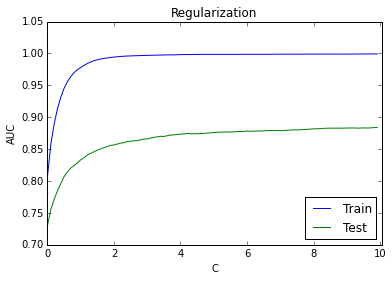

In [165]:
plt.title('Regularization')
plt.plot(reg_param, auc_scores_train, label = 'Train')
plt.plot(reg_param, auc_scores_test, label = 'Test')
plt.xlabel('C')
plt.ylabel('AUC')
plt.xlim([0,10.05])
plt.ylim([0.7,1.05])
plt.legend(loc="lower right")
plt.show()

##Подход на основе word2vec

План действий:
    1. Импорт предаврительно обученной w2v модели
    2. Построение кластеров по векторам слов
    3. Замена слов кластерами, к которыми они принадлежат
    4. Обучении классификатора на полученных данных о кластерах

In [121]:
# Импорт обученной на поисковых запросах Google модели w2v
from gensim.models import word2vec
w2v_model = word2vec.Word2Vec.load_word2vec_format("/home/m.v.surovikov/.ipython/data/google w2v/GoogleNews-vectors-negative300.bin", binary=True)

In [122]:
# Некоторые возможности модели
w2v_model.most_similar('skype')

[(u'skyping', 0.6214301586151123),
 (u'SKYPE', 0.6148898601531982),
 (u'Gtalk', 0.6096575856208801),
 (u'MSN_messenger', 0.6021869778633118),
 (u'GTalk', 0.5990498065948486),
 (u'gmail', 0.5981154441833496),
 (u'Skype', 0.5911428928375244),
 (u'fone', 0.5836682319641113),
 (u'ichat', 0.5790513157844543),
 (u'aol', 0.5735843181610107)]

In [123]:
w2v_model.similarity('cat', 'dog')

0.76094570897822089

In [124]:
w2v_model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)

[(u'queen', 0.7118192315101624)]

In [125]:
# Длина вектора каждого слова
len(w2v_model['computer'])

300

In [126]:
# Список списокв извлеченных из текстов слов
words_train =  [[x for x in re.findall(r"[\w']+", y)] for y in twenty_train.data]

words_test =  [[x for x in re.findall(r"[\w']+", y)] for y in twenty_test.data]

In [127]:
# Объединение всех слов из выборки в один уникальный список
unique_words_train = list(set([item for sublist in words_train for item in sublist]))

In [128]:
# Число уникальных слова в обучающей выборке
len(unique_words_train)

18887

In [129]:
# Формирование словаря слово - вектор по имеющимся словам
word_vectors = {}
for x in unique_words_train:
    try:
        word_vectors[x] = w2v_model[x]
    except:
        pass

In [130]:
# Число слов, для которых нашлись значения в используемой модели
len(word_vectors)

16242

In [131]:
# Обучение Kmeans
from sklearn.cluster import KMeans
cluster_model = KMeans(n_clusters=200, random_state=1, n_jobs=7).fit(word_vectors.values())

In [132]:
# Формирование словаря слово - кластер
word_x_cluster = dict(zip(word_vectors.keys(), cluster_model.predict(word_vectors.values())))

In [133]:
# Близкие слова попали в один кластер
print word_x_cluster['I']
print word_x_cluster['me']

12
12


In [134]:
# Функция, возвращающая кластер по слову
def word_to_cluster(word):
    res = ''
    try:
        res = str(word_x_cluster[x])
    except:
        pass
    return res

In [135]:
w2v_data_train = [' '.join([word_to_cluster(x) for x in y]) for y in words_train]

In [136]:
# Слова заменены на номера кластеров
w2v_data_train[0]

'195 12 139 91 69  102 65 12 190 63 196  110 12 91 133 192 91 91 158 170  110  91  136 41 110 193 65 193 21 164 69 91 91 27 85 14 41 69 39  80 91 110 110 91 91 155  115 14 164 139 107 63 155 39 114 91  12 49 91 67  110 34 91 75 91 12 12 91 91 123  75 91 93 91 166 39 91 12  75 91 93 93 41 110 91 164 110 28 91 63 14 91 136 49 12 24 91 49  91 91 181 14 41 91 69 133 82 91 12 49 164  91 91 196  9 12 12 139 110 39 78 110 91 110 91 69 164 195 12 184 110  139 91 91  155  115'

In [137]:
w2v_data_test = [' '.join([word_to_cluster(x) for x in y]) for y in words_test]

In [138]:
vc = TfidfVectorizer()
vectorized_text['Word2Vec'] = vc.fit_transform(w2v_data_train)

In [139]:
run_cv('Word2Vec', stemming = False)


Word2Vec

        C  AUC test std  AUC test mean  AUC train std  AUC train mean
0    0.01      0.000000       0.500000       0.000000        0.500000
1    0.05      0.000000       0.500000       0.000000        0.500000
2    0.10      0.041566       0.633750       0.010524        0.632500
3    0.30      0.041645       0.633933       0.013210        0.636893
4    0.50      0.049919       0.681892       0.015044        0.700751
5    1.00      0.047434       0.717535       0.010219        0.788482
6    2.00      0.035044       0.747811       0.004526        0.851196
7    4.00      0.026526       0.754477       0.003265        0.879552
8    6.00      0.022125       0.750167       0.002793        0.889980
9   10.00      0.017721       0.743028       0.002530        0.897996
10  15.00      0.016482       0.737480       0.002871        0.902015
11  20.00      0.015192       0.733523       0.003023        0.904333
12  25.00      0.015507       0.729934       0.003223        0.905848
13  30.00

In [141]:
df_auc_agg.sort(('CV AUC'), ascending=False)

,Vectorizer,Stemming,C,CV AUC
5,TFIDFVect,True,6.0,0.819478
2,TFIDFVect,False,6.0,0.819478
3,CountVect,True,0.5,0.793141
0,CountVect,False,0.5,0.793096
4,CountVectBin,True,1.0,0.790886
1,CountVectBin,False,1.0,0.790885
6,Word2Vec,False,4.0,0.754477


In [145]:
# Обучение лучшей модели на всей обучающей выборке и расчет AUC на обучающей и тестовой выборках
best_model_w2v = LogisticRegression(class_weight = 'auto', penalty = 'l1', C = 4.0).fit(vectorized_text['Word2Vec'], train_labels)

In [147]:
vectorized_text_w2v_test = vc.transform(w2v_data_test)
test_auc = roc_auc_score(y_labels = test_labels, y_predicted = best_model_w2v.predict_proba(vectorized_text_w2v_test)[:, 1])
print 'Test AUC = ' + str(test_auc)

Test AUC = 0.695769685079
